In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.linalg import svd

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import os.path as osp

/opt/anaconda3/envs/tedana-hack/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# PATH DATA
MASK_Path = '/opt/tedana-hack/tedana/docs/FA-test/data/GIFT_mask.nii'
OC_Path   = '/opt/tedana-hack/tedana/docs/FA-test/data/sbj.OCTS.nii'

In [3]:
# LOAD DATA
DATA = apply_mask(OC_Path, MASK_Path).T
[Nv,Nt] = DATA.shape
print ('DATA: Number of Voxels %d' % Nv)
print ('DATA: Number of Time points %d' % Nt)

DATA: Number of Voxels 24586
DATA: Number of Time points 160


DATA_sc[(24586, 160)] --> 0.000000 +/- 1.000000 


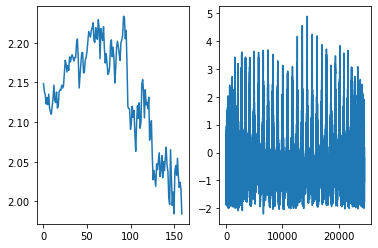

In [5]:
scaler = StandardScaler(with_mean=True, with_std=True)
DATA_sc = scaler.fit_transform(DATA)
rep_acq = 100
rep_v   = 5000
print('DATA_sc[%s] --> %f +/- %f ' % (str(DATA_sc.shape),np.mean(DATA_sc[:,rep_acq]),np.std(DATA_sc[:,rep_acq])))
plt.subplot(1,2,1);plt.plot(DATA_sc[rep_v,:])
plt.subplot(1,2,2);plt.plot(DATA_sc[:, rep_acq])


In [6]:
_, eigen_vals, vh = svd(DATA_sc)

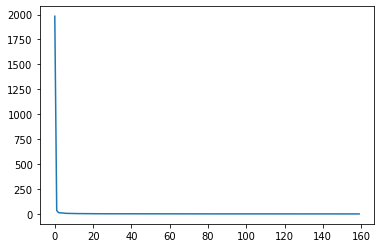

In [7]:
plt.plot(eigen_vals)

In [10]:
eigen_vals.shape

(160,)

In [9]:
print(eigen_vals/np.sqrt(DATA_sc.shape[0]-1))

[1.26463118e+01 2.16258809e-01 8.23769942e-02 7.05257580e-02
 5.39527759e-02 4.16603163e-02 3.83679494e-02 3.47500034e-02
 2.96567641e-02 2.81430837e-02 2.61926185e-02 2.43684035e-02
 2.33486742e-02 2.19268613e-02 2.08634455e-02 1.99911706e-02
 1.82711221e-02 1.72962658e-02 1.72759946e-02 1.58808548e-02
 1.51222674e-02 1.49340769e-02 1.40938535e-02 1.26222074e-02
 1.23607423e-02 1.21049583e-02 1.17402086e-02 1.10928509e-02
 1.09015768e-02 1.06041534e-02 1.04113864e-02 1.02866013e-02
 9.98750050e-03 9.74094402e-03 9.25033819e-03 9.18885227e-03
 8.99968296e-03 8.95921607e-03 8.65083560e-03 8.53558443e-03
 8.38238373e-03 8.26935191e-03 8.08264315e-03 8.05747136e-03
 7.96304550e-03 7.87901320e-03 7.60940509e-03 7.50736054e-03
 7.38241710e-03 7.25875422e-03 7.19568878e-03 7.04771187e-03
 6.92996196e-03 6.84056804e-03 6.70610275e-03 6.61092158e-03
 6.50732592e-03 6.41426304e-03 6.38464140e-03 6.30180165e-03
 6.26829546e-03 6.12226501e-03 6.06626226e-03 6.03542151e-03
 6.00486482e-03 5.914693

In [18]:
gift_eigens = np.diag(np.loadtxt('./data/gift_eigens.txt'))

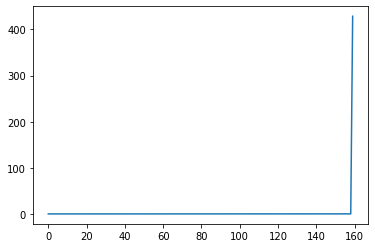

In [21]:
plt.plot(gift_eigens / eigen_vals)